In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import spyrit.core.torch as st

In [2]:
def generate_heterogeneous_data(n, p, imbalance_factor=10, random_seed=42):
    np.random.seed(random_seed)
    
    # Parameters for two components
    # Component 1: Standard variance, centered at 0
    mu1 = np.zeros(p)
    sigma1 = np.eye(p)
    
    # Component 2: High variance, shifted mean and scaled covariance
    mu2 = np.ones(p) * 5  # Shifted mean
    sigma2 = np.eye(p) * imbalance_factor  # High variance component
    
    # Define mixing proportions (say, 80% from component 1 and 20% from component 2)
    weights = [0.8, 0.2]
    
    # Generate data for each component
    n1 = int(n * weights[0])
    n2 = n - n1
    X1 = np.random.multivariate_normal(mu1, sigma1, size=n1)
    X2 = np.random.multivariate_normal(mu2, sigma2, size=n2)
    
    # Combine the data
    X = np.vstack((X1, X2))
    np.random.shuffle(X)
    epsilon = np.random.normal(0, 1, size=n)
    beta = np.random.normal(0, 1, size=p)
    Y = np.dot(X, beta) + epsilon
    return X, Y, beta

In [3]:
X,Y,beta = generate_heterogeneous_data(8192,250,10,39)

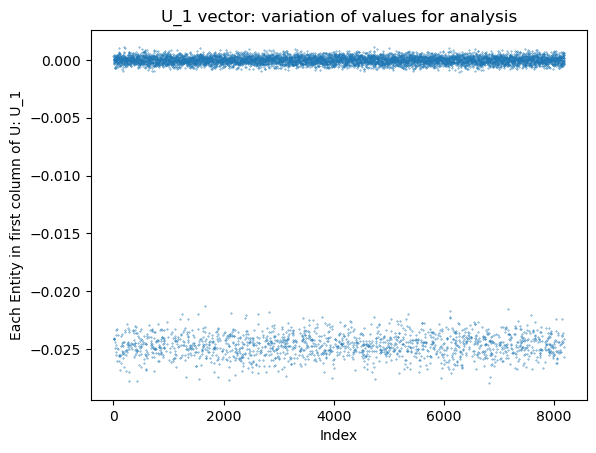

In [4]:
# Compute the singular decomposition of matrix X, X = (U)(Σ)(V^T)
U, s, Vh = np.linalg.svd(X)
# U_1 is the first column of matrix U, which represents the principal direction of variation in X
U_1 = U[:, 0]

# Plot singular values using a dot plot
plt.scatter(range(len(U_1)), U_1,s = 0.1)
plt.xlabel('Index')
plt.ylabel('Each Entity in first column of U: U_1')
plt.title('U_1 vector: variation of values for analysis')
plt.show()

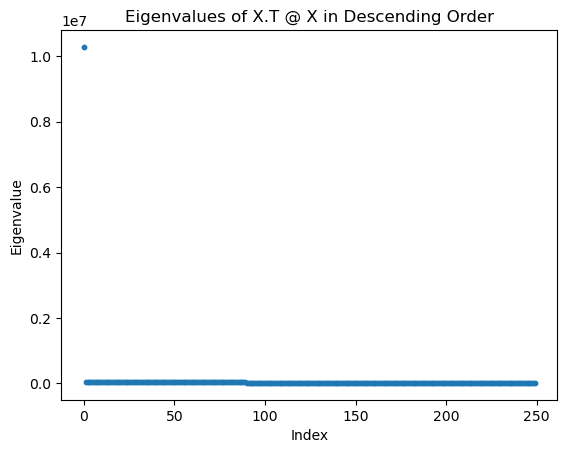

In [5]:
# Since X is non-square (8192 x 250), we compute the eigenvalue decomposition of X.T @ X (a 250 x 250 matrix)
eigvals, eigvecs = np.linalg.eig(X.T @ X)

# Sort eigenvalues in descending order
sorted_eigvals = np.sort(eigvals)[::-1]

# Scatter plot of the sorted eigenvalues
plt.scatter(range(len(sorted_eigvals)), sorted_eigvals, s=10)
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of X.T @ X in Descending Order")
plt.show()

In [6]:
# Step 1: Hadamard rademacher randomization
def fhm(X,Y):
    # Generate a diagonal matrix of -1 or 1 with 0.5 probability
    diag_matrix = np.diag(np.random.choice([-1, 1], size=X.shape[0]))
    signs = diag_matrix
    # Multiply each row of X and Y by the corresponding sign
    result_X = np.dot(signs, X)
    result_Y = np.dot(signs, Y)
    # Convert to PyTorch tensor with float64
    tensor_matrix_X = torch.tensor(result_X, dtype=torch.float64)
    tensor_matrix_Y = torch.tensor(result_Y, dtype=torch.float64)
    # Apply FWHT
    tensor_matrix_X = st.fwht(tensor_matrix_X.T).T
    tensor_matrix_Y = st.fwht(tensor_matrix_Y)
    # Convert back to numpy array
    X = tensor_matrix_X.numpy() / np.sqrt(X.shape[0])
    Y = tensor_matrix_Y.numpy() / np.sqrt(Y.shape[0])
    return X, Y
X_hadamard, Y_hadamard = fhm(X,Y)
## subsampled X_hadamard to contain only 0.2 of its rows, index 1 for selected, 0 for not selected
subsample_ratio = 0.2
num_rows = X_hadamard.shape[0]
S_matrix = np.zeros((num_rows, num_rows))
selected_indices = np.random.choice(num_rows, size=int(num_rows * subsample_ratio), replace=False)
for idx in selected_indices:
    S_matrix[idx, idx] = 1
X_transformed = S_matrix @ X_hadamard
Y_transformed = S_matrix @ Y_hadamard
print(X_transformed.shape)
print(Y_transformed.shape)

(8192, 250)
(8192,)


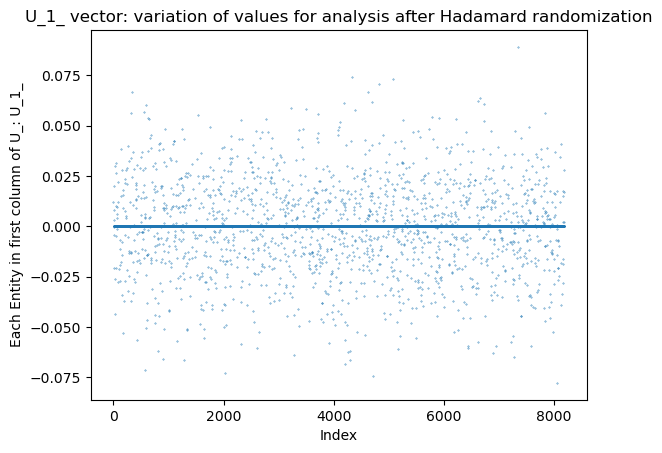

In [7]:
# Compute the singular decomposition of matrix X, X = (U)(Σ)(V^T)
U_, s_, Vh_ = np.linalg.svd(X_transformed)
# U_1_ is the first column of matrix U, which represents the principal direction of variation in X
U_1_ = U_[:, 0]

# Plot singular values using a dot plot
plt.scatter(range(len(U_1_)), U_1_,s = 0.1)
plt.xlabel('Index')
plt.ylabel('Each Entity in first column of U_: U_1_')
plt.title('U_1_ vector: variation of values for analysis after Hadamard randomization')
plt.show()

In [8]:
def partition_matrix(X,Y,k):
    """
    Partition the rows of matrix X across k machines uniformly with equal probability.
    Each machine will receive a sub-matrix of X and the corresponding sub-vector of Y.

    Parameters:
    X (numpy.ndarray): The input matrix to be partitioned (n rows, m columns).
    Y (numpy.ndarray): The output vector to be partitioned (n rows, 1 column).
    k (int): The number of machines.

    Returns:
    list of numpy.ndarray: A list of sub-matrices, each assigned to a machine.
    """
    # Get the number of rows in the matrix
    n = X.shape[0]
    
    # Create an array of row indices (0 to n-1)
    indices = np.arange(n)
    
    # Shuffle the indices randomly to ensure each row has equal probability
    np.random.shuffle(indices)
    
    # Calculate the base size of each partition and the remainder
    part_size = n // k  # Base number of rows per machine
    remainder = n % k   # Extra rows to distribute
    
    # Split the indices into k parts
    parts = []
    start = 0
    for i in range(k):
        # The first 'remainder' machines get one extra row
        end = start + part_size + (1 if i < remainder else 0)
        parts.append(indices[start:end])
        start = end
    
    # Create sub-matrices for each machine using the partitioned indices
    sub_matrices = [X[part] for part in parts]
    sub_matrices_Y = [Y[part] for part in parts]
    
    return sub_matrices, sub_matrices_Y

In [9]:
beta_ols_X = np.linalg.inv(X.T @ X) @ (X.T @ Y)
def LA_without_noise(A,beta):
    return np.dot(A,beta)
def LA_REAL_difference(A,beta_to_fulfill):
    La = LA_without_noise(A,beta)
    La_hat = LA_without_noise(A,beta_to_fulfill)
    return np.sum((La-La_hat)**2)
difference_ols = LA_REAL_difference(np.eye(X.shape[1]),beta_ols_X)

In [10]:
def average_regression_train(X,Y,k):
    sub_matrices,sub_target = partition_matrix(X,Y,k)
    solution_list = []
    for i in range(k):
        X_i = sub_matrices[i]
        Y_i = sub_target[i]
        X_i = np.array(X_i)
        Y_i = np.array(Y_i)
        # Compute the regression coefficients for each machine
        beta_i = np.linalg.inv(X_i.T @ X_i) @ (X_i.T @ Y_i)
        solution_list.append(beta_i)
    # Average the coefficients across all machines
    beta_avg = np.average(solution_list, axis=0)
    return beta_avg

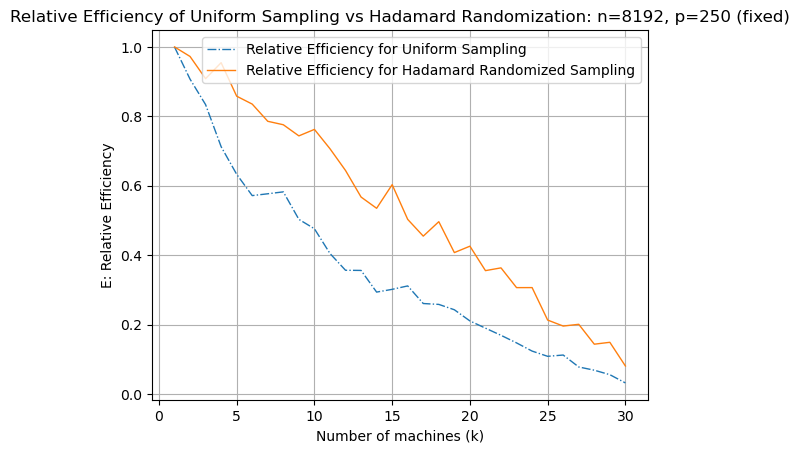

In [11]:
E_uniform_sampling = []
E_hadamard_randomization = []
for i in range(30):
    num = i + 1
    difference_us = LA_REAL_difference(np.eye(X.shape[1]),average_regression_train(X,Y,num))
    E_uniform_sampling.append(difference_ols/difference_us)
    difference_hadamard = LA_REAL_difference(np.eye(X.shape[1]),average_regression_train(X_hadamard,Y_hadamard,num))
    E_hadamard_randomization.append(difference_ols/difference_hadamard)
plt.plot(range(1, 31), E_uniform_sampling, label='Relative Efficiency for Uniform Sampling',linestyle = '-.',linewidth = 1)
plt.plot(range(1, 31), E_hadamard_randomization, label='Relative Efficiency for Hadamard Randomized Sampling',linestyle = '-',linewidth = 1)
plt.xlabel('Number of machines (k)')
plt.ylabel('E: Relative Efficiency')
plt.title('Relative Efficiency of Uniform Sampling vs Hadamard Randomization: n=8192, p=250 (fixed)')
plt.legend()
plt.grid()
plt.show()

In [12]:
#Expected Efficiency,DELTA^2 = 1
def MSE(X,A,delta = 1):
    return (delta**2)*np.trace(np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(A.T,A)))
MSE_ols = MSE(X,np.eye(X.shape[1]),delta = 1)
print("MSE_ols: ", MSE_ols)

MSE_ols:  0.011754764580688148


In [13]:
def average_MSE_expectation(X,Y,k,delta = 1):
    sub_matrices,sub_target = partition_matrix(X,Y,k)
    mse_pre = 0
    for i in range(k):
        X_i = sub_matrices[i]
        Y_i = sub_target[i]
        X_i = np.array(X_i)
        Y_i = np.array(Y_i)
        MSE_gained = MSE(X_i,np.eye(X_i.shape[1]),delta)
        MSE_gained = MSE_gained * ((1/k)**2)
        mse_pre += MSE_gained
    return mse_pre
def Relative_Efficiency(MSE_ols,X,Y,k,delta=1):
    mse = average_MSE_expectation(X,Y,k,delta)
    return MSE_ols/mse

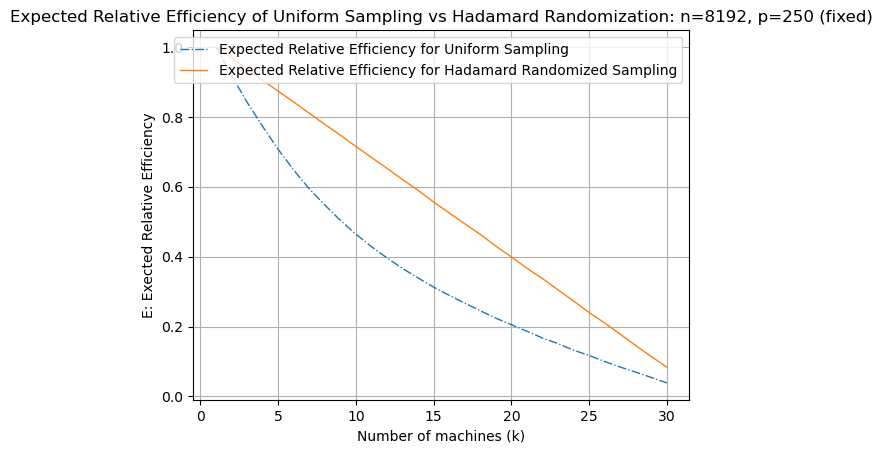

In [14]:
#Relative Efficiency Plot
Expected_E_US = []
Expected_E_HR = []
for i in range(30):
    num = i + 1
    E_us = Relative_Efficiency(MSE_ols,X,Y,num,delta=1)
    Expected_E_US.append(E_us)
    E_hr = Relative_Efficiency(MSE_ols,X_hadamard,Y_hadamard,num,delta=1)
    Expected_E_HR.append(E_hr)
plt.plot(range(1, 31), Expected_E_US, label='Expected Relative Efficiency for Uniform Sampling',linestyle = '-.',linewidth = 1)
plt.plot(range(1, 31), Expected_E_HR, label='Expected Relative Efficiency for Hadamard Randomized Sampling',linestyle = '-',linewidth = 1)
plt.xlabel('Number of machines (k)')
plt.ylabel('E: Exected Relative Efficiency')
plt.title('Expected Relative Efficiency of Uniform Sampling vs Hadamard Randomization: n=8192, p=250 (fixed)')
plt.legend()
plt.grid()
plt.show()